In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras
import tensorflow as tf
import numpy as np
from numpy  import expand_dims
import cv2
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
np.random.seed(15)

Using TensorFlow backend.


# 0. Data preprocessing(데이터 전처리)

- 데이터는 네트워크에 주입되기 전에 floating 타입의 텐서로 적절하게 전처리되어 있어야 함
- 데이터가 JPEG 파일로 되어 있을 때, <ins>**네트워크에 주입**</ins>하려면 대략 다음 과정을 따름
    1. 사진 파일을 읽음
    2. JPEG 콘턴츠를 RGB 픽셀 값으로 디코딩함
    3. floating 타입의 텐서로 변환
    4. 픽셀 값(0 ~ 255)의 스케일을 [0,1]사이로 조정(**신경망은 작은 입력 값을 선호하기 때문**)


- 케라스에는 keras.preprocessing.image라는 유틸리티가 위의 과정들을 자동으로 처리해줌
- 특히 **ImageDataGenerator** 클래스는 (디스크에 있는 이미지 파일)-->(전처리된 배치 텐서)로 자동으로 바꾸어 주는 파이썬 generator를 만들어 줌

-----

### <font color='red'>keras.preprocessing.image.ImageDataGenerator</font>(<ins>rotation_range</ins>=0, <ins>width_shift_range</ins>=0.0, <ins>height_shift_range</ins>=0.0, <ins>brightness_range</ins>=None, <ins>shear_range</ins>=0.0, <ins>zoom_range</ins>=0.0, <ins>channel_shift_range</ins>=0.0, <ins>fill_mode</ins>='nearest', <ins>horizontal_flip</ins>=False, <ins>vertical_flip</ins>=False, <ins>rescale</ins>=None)


Parameters:
- **rotation_range** : Int. Degree range for random rotations.
- **width_shift_range** : <ins>Float</ins>, <ins>1-D array-like</ins> or <ins>int</ins>
    - **float** : fraction of total width, if < 1, or pixels if >= 1.
    - **1-D array-like** : random elements from the array.
    - **int** : integer number of pixels from interval `(-width_shift_range, +width_shift_range)`
    - With `width_shift_range=2` possible values are integers `[-1, 0, +1]`, same as with `width_shift_range=[-1, 0, +1]`, while with `width_shift_range=1.0` possible values are floats in the interval [-1.0, +1.0).

- **height_shift_range** : <ins>Float</ins>, <ins>1-D array-like</ins> or <ins>int</ins>
    - **float** : fraction of total height, if < 1, or pixels if >= 1.
    - **1-D array-like** : random elements from the array.
    - **int** : integer number of pixels from interval `(-height_shift_range, +height_shift_range)`
    - With `height_shift_range=2` possible values are integers `[-1, 0, +1]`, same as with `height_shift_range=[-1, 0, +1]`, while with `height_shift_range=1.0` possible values are floats in the interval [-1.0, +1.0).
    
- **brightness_range** : Tuple or list of two floats. Range for picking a brightness shift value from.
- **shear_range** : Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
- **zoom_range** : Float or [lower, upper]. Range for random zoom. If a float, `[lower, upper] = [1-zoom_range, 1+zoom_range]`.
- **channel_shift_range** : Float. Range for random channel shifts.
- **fill_mode** : One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. Points outside the boundaries of the input are filled according to the given mode:
    - **'constant'** : kkkkkkkk|abcd|kkkkkkkk (cval=k)
    - **'nearest'** : aaaaaaaa|abcd|dddddddd
    - **'reflect'** : abcddcba|abcd|dcbaabcd
    - **'wrap'** : abcdabcd|abcd|abcdabcd
- **horizontal_flip** : Boolean. Randomly flip inputs horizontally.
- **vertical_flip** : Boolean. Randomly flip inputs vertically.
- **rescale** : rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).


### Ref : https://keras.io/preprocessing/image/

# 1. Data Augmentation


dataset 이 너무 적은 경우 overfitting 문제가 발생함

![data augmetation](keras_data_augmentation_jitter.png)


keras에서는 dta augmentation을 통해 해결


- Translations
- Rotations
- Changes in scale
- Shearing
- Horizontal (and in some cases, vertical) flips

![image data augmetation](keras_data_augmentation_random_adjustments.jpg)


### Type 1: existing dataset을 사용해 학습 dataset를 재구성함(Old version)
  
<img src=keras_data_augmentation_dataset_generation.png width=300>

### Type 2: In-place/on-the-fly data augmentation - keras에서 구현(Recomended version!)
- batch 수 만큼 ImageDataGenerator로 실시간 생성 후 원본 제외하고 생성된 데이터 셋으로 학습

<img src=keras_data_augmentation_in_place.png width=300>

### 잘못된 방식
<img src=keras_data_augmentation_incorrect.png  width=300>

In [6]:
img = tf.keras.preprocessing.image.load_img('cat.jpg')  # 이미지 객체임
data = tf.keras.preprocessing.image.img_to_array(img)   # data 만 추출
print(data.shape)
sample = expand_dims(data,0)
print(sample.shape)

(720, 1280, 3)
(1, 720, 1280, 3)


In [5]:
# opencv 사용해 이미지 loaidng하는 또다른 방법
# data = cv2.imread('cat.jpg')
# data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) # opencv 채널로 읽어들일 때는 반드시 RGB로 변환시켜줘야 함!
# sample = expand_dims(data,0)
# print(sample.shape)

(1, 720, 1280, 3)


---

수평, 수직 이동

In [54]:
# 어떤 기하학적인 변형을 쓸 것인지 설정
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range = 0.2)

obj = generator.flow(sample, batch_size=1) 

(1, 720, 1280, 3)
float32


(720, 1280, 3)


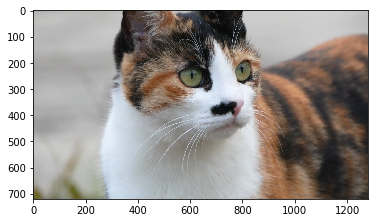

In [55]:
# 할때마다 다른 이미지 나온다.
image = obj.next()
print(image.shape)
print(image.dtype) # obj 함수로 리턴되는 객체는 float타입의 객체
print('\n')
print(image[0].shape)
# plt.imshow(image[0].astype('uint8') )  #  plt로 할때는 0~1사이로  혹은 타입을 uint8로
plt.imshow(image[0]/255)  #  plt로 할때는 0~1사이로  혹은 타입을 uint8로 

In [56]:
# 위에랑 똑같음

generator = tf.keras.preprocessing.image.ImageDataGenerator(    
    width_shift_range = 0.2, rescale=1./255)   # rescale 해주면 정규화하고, imshow할때 type변한 필유없다.
obj = generator.flow(sample, batch_size=1)   

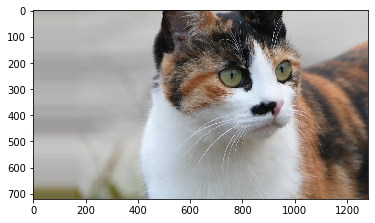

In [57]:
image = obj.next()
plt.imshow(image[0] )

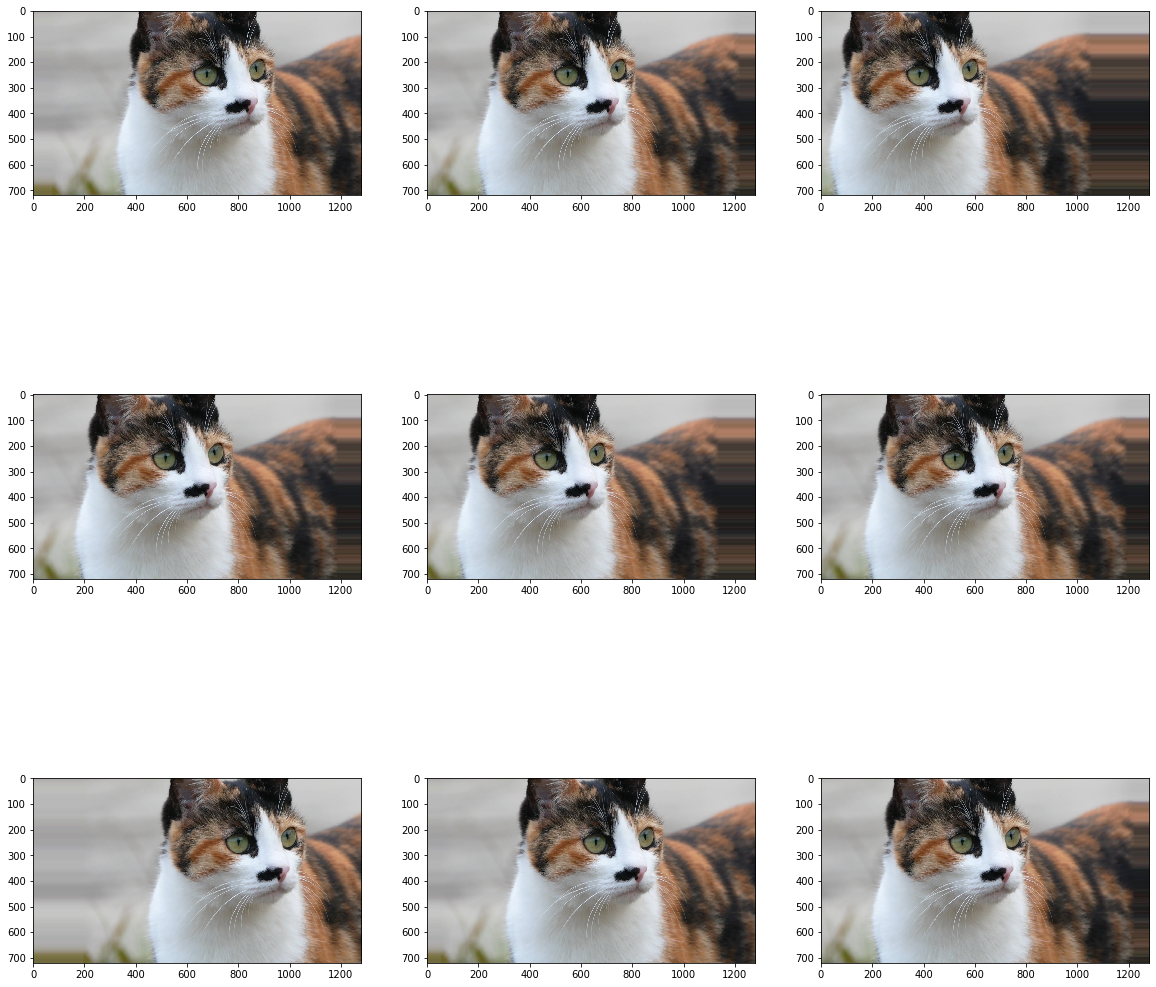

In [58]:
fig = plt.figure(figsize=(20,20))
for i in range(9) :
    plt.subplot(3,3,i+1)
    image = obj.next()
    plt.imshow(image[0])  

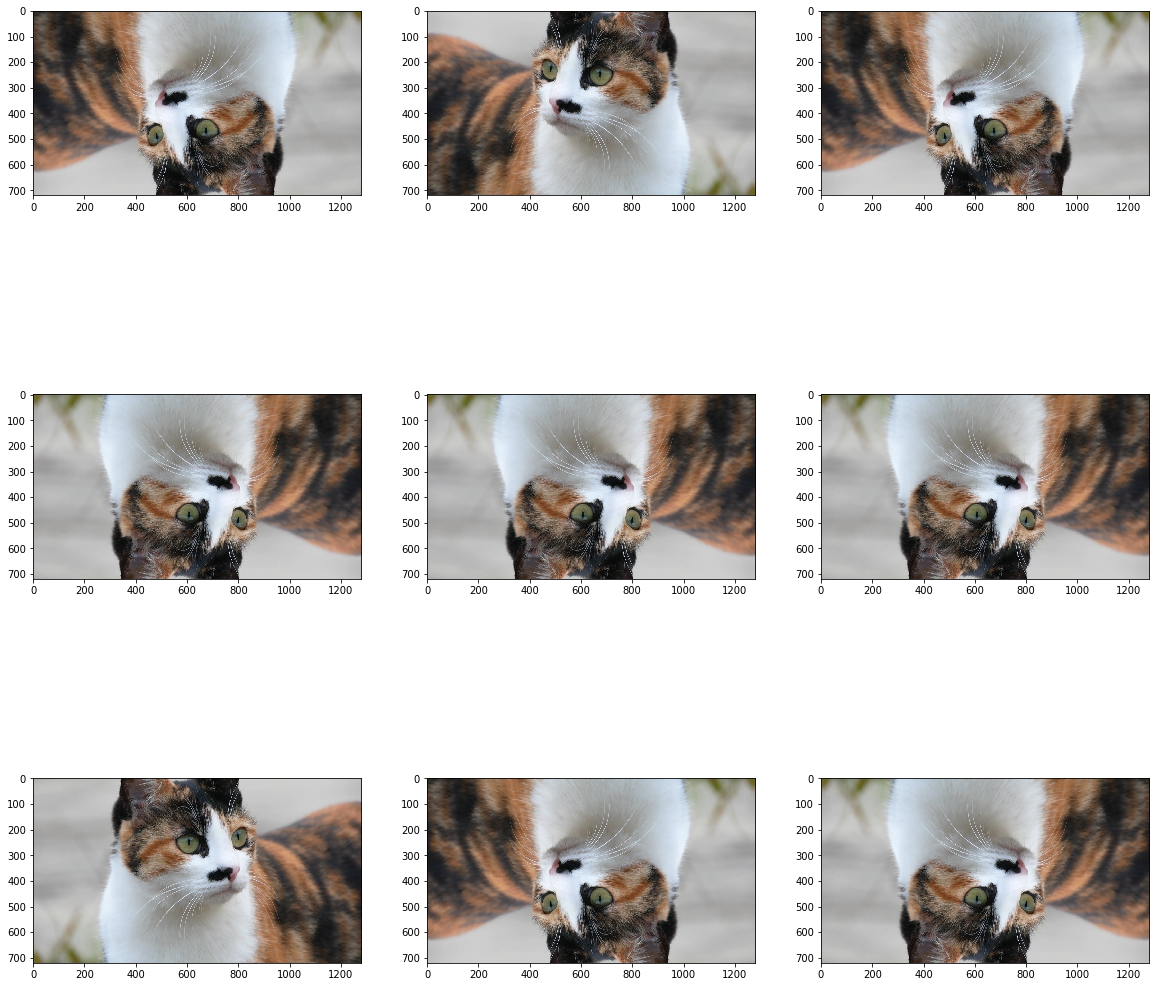

In [59]:
# flip(반전)이 들어간 코드
generator = tf.keras.preprocessing.image.ImageDataGenerator( 
    horizontal_flip = True, vertical_flip = True,
    rescale=1./255)
obj = generator.flow(sample, batch_size=1)   

fig = plt.figure(figsize=(20,20))
for i in range(9) :
    plt.subplot(3,3,i+1)
    image = obj.next()
    plt.imshow(image[0])   

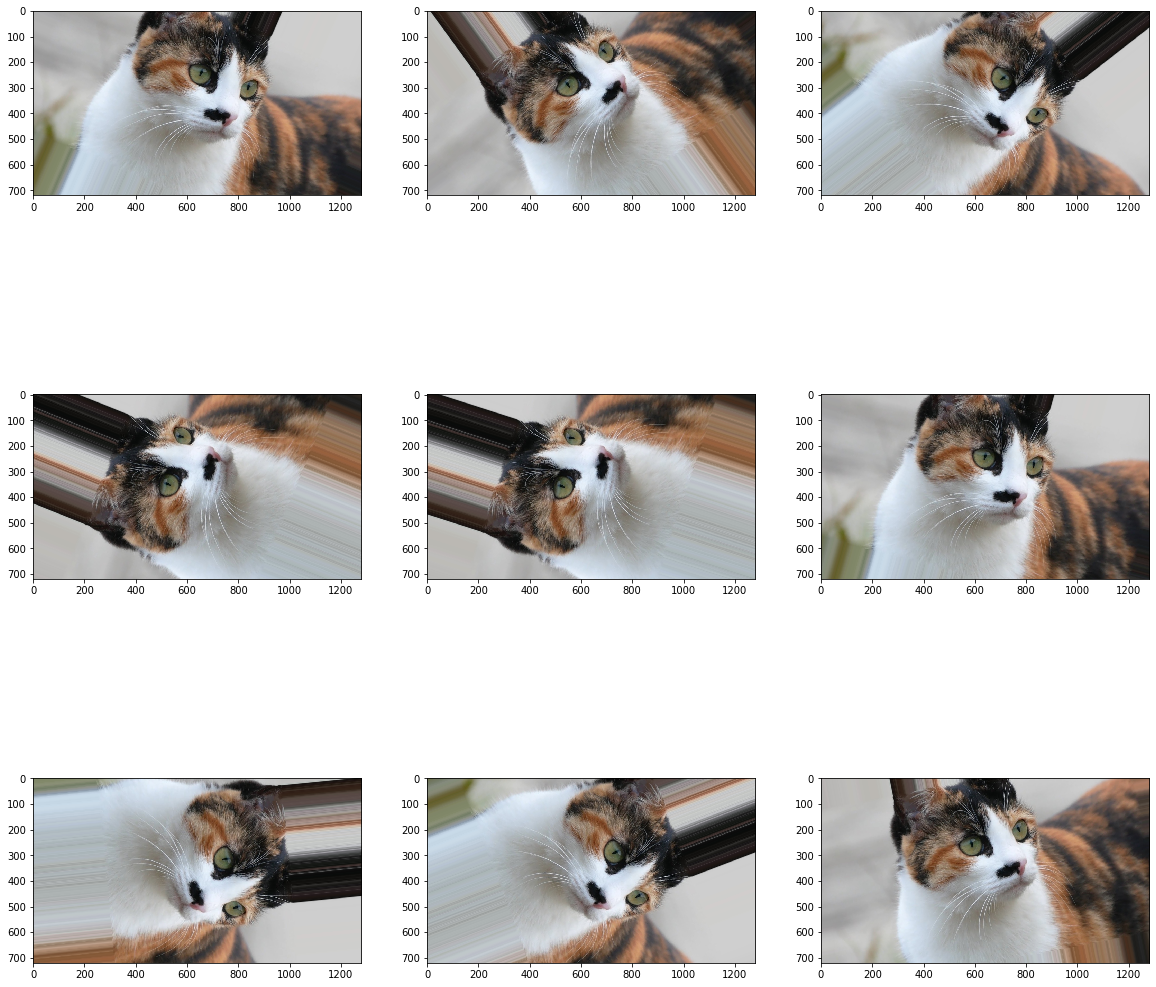

In [60]:
# rotation과 rescale이 들어간 코드
generator = tf.keras.preprocessing.image.ImageDataGenerator( 
    rotation_range=90,
    rescale=1./255)
obj = generator.flow(sample, batch_size=1)   

fig = plt.figure(figsize=(20,20))
for i in range(9) :
    plt.subplot(3,3,i+1)
    image = obj.next()
    plt.imshow(image[0])   
    

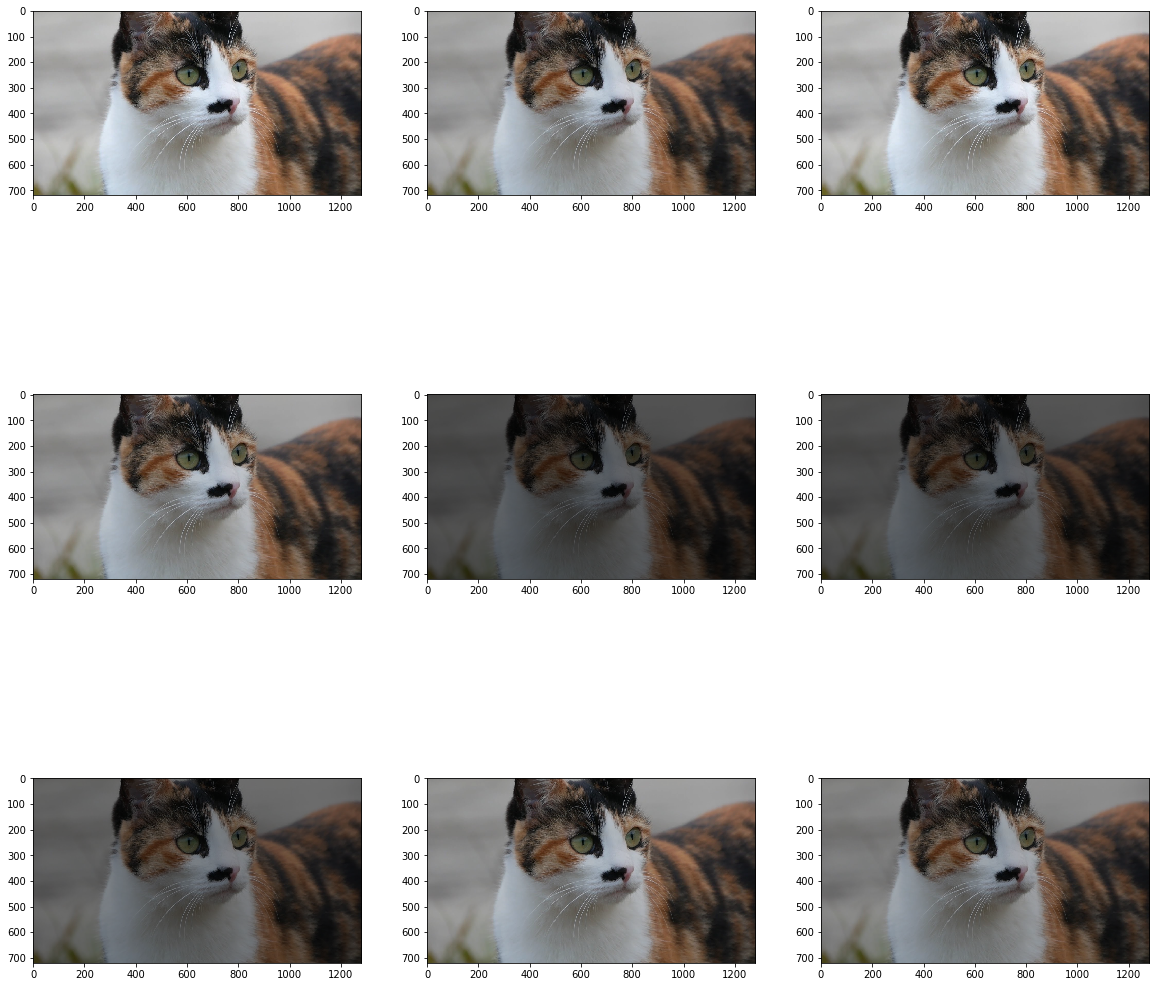

In [61]:
# 밝기와 rescale이 들어간 코드
generator = tf.keras.preprocessing.image.ImageDataGenerator( 
    brightness_range=[0.2, 1.0],       
    rescale=1./255)
obj = generator.flow(sample, batch_size=1)   

fig = plt.figure(figsize=(20,20))
for i in range(9) :
    plt.subplot(3,3,i+1)
    image = obj.next()
    plt.imshow(image[0])   

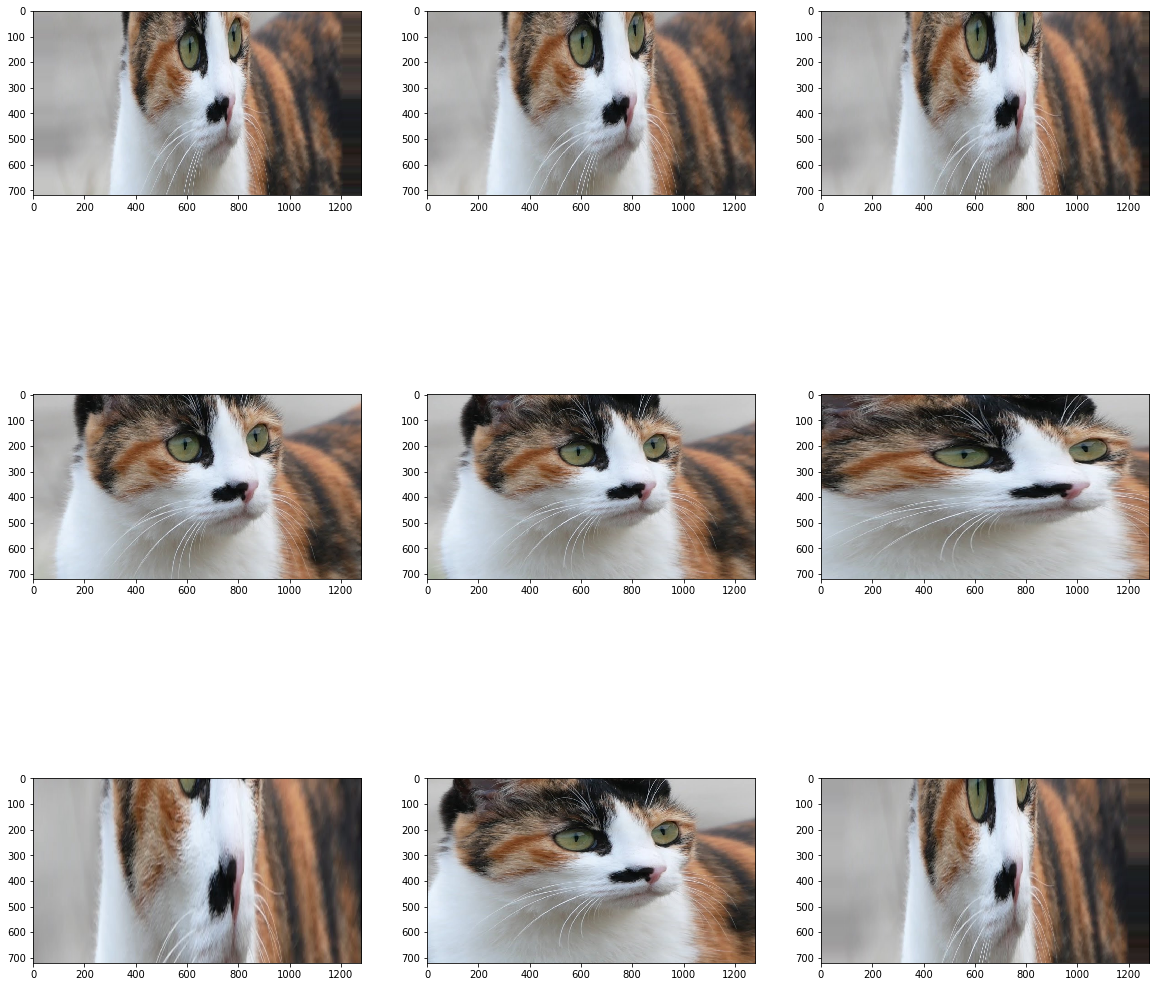

In [62]:
# zoom_range와 rescale이 들어간 코드
generator = tf.keras.preprocessing.image.ImageDataGenerator( 
    zoom_range=[0.2, 1.2],   
    rescale=1./255)
obj = generator.flow(sample, batch_size=1)   

fig = plt.figure(figsize=(20,20))
for i in range(9) :
    plt.subplot(3,3,i+1)
    image = obj.next()
    plt.imshow(image[0])   

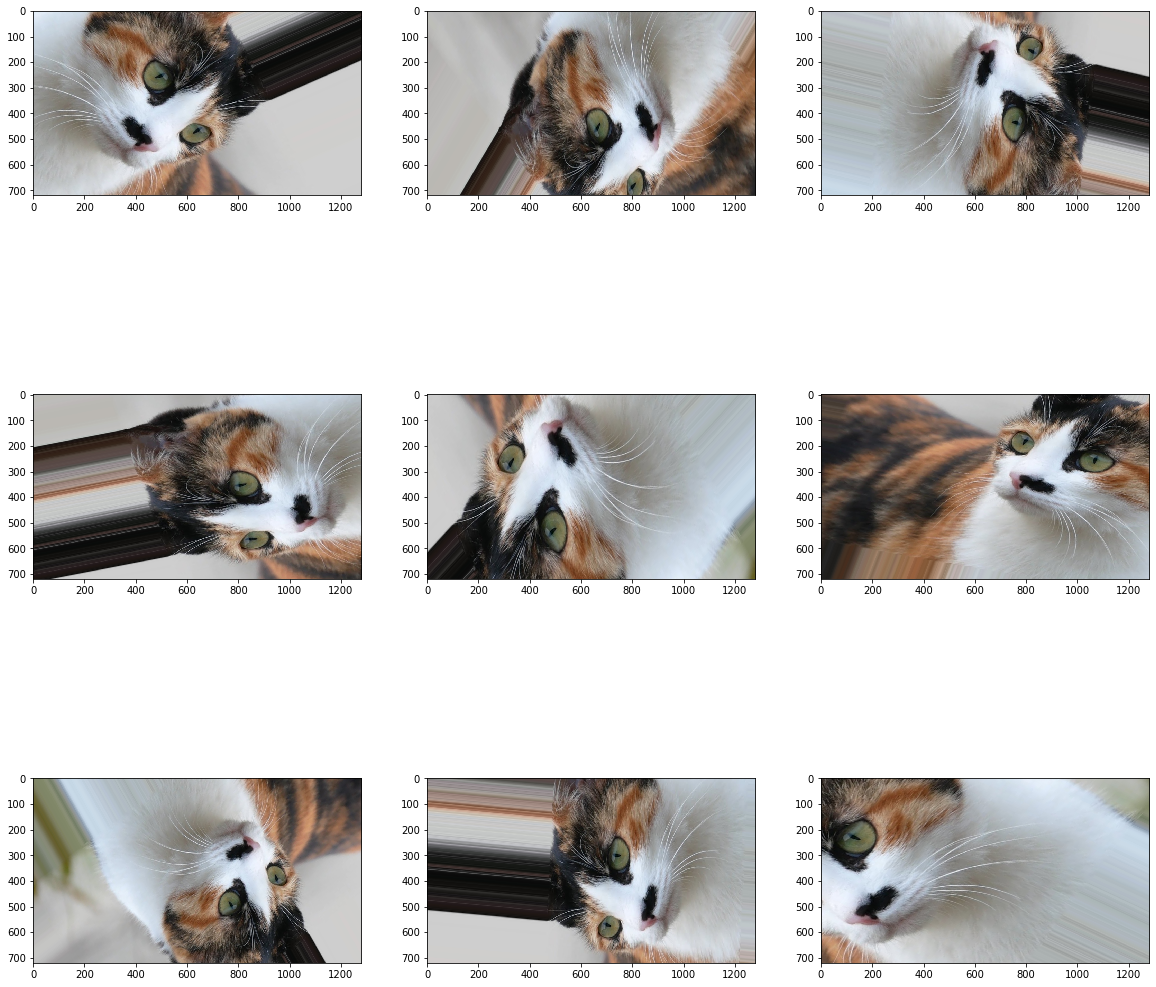

In [63]:
# 한꺼번에 적용하기
generator = tf.keras.preprocessing.image.ImageDataGenerator( 
    width_shift_range = 0.2,
    zoom_range=[0.5, 1.0],   
    horizontal_flip = True, vertical_flip = True,
    rotation_range=90,
    rescale=1./255)
obj = generator.flow(sample, batch_size=1)   

fig = plt.figure(figsize=(20,20))
for i in range(9) :
    plt.subplot(3,3,i+1)
    image = obj.next()
    plt.imshow(image[0])   

In [65]:
# 파일로 저장하기
obj = generator.flow(sample, batch_size=1, save_to_dir='tmp',  # tmp폴더는 생성되어 있어야 함
    save_prefix="image", save_format="jpg")    

for i in range(0, 5):
    obj.next()    

In [68]:
# 2.  디렉토리로 부터 augmentation
#augsample/c1/2개 이미지
#augsample/c2/6개 이미지    
#augsample/c3/1개 이미지    

obj = generator.flow_from_directory(
    'hard_handwriting_shape',
    target_size = (150, 150),   # 읽어드릴 이미지, 이미지 크기를 맞춰야 하기 때문에 생략시 256x256
    batch_size = 4,   # 8개 이미지 중에서 한번에 생성할 이미지 수 
    class_mode = 'binary' )  # # binary(label) --> 벡터  |  categorical(one-hot) --> 행렬  (한 번 체크해보는 것도 괜찮음)



Found 75 images belonging to 3 classes.


In [69]:
iterations = 2

for i, (img, label) in enumerate(obj):
    n_img = len(label)    # 폴더에 있는 이미지 갯수 만큼 리턴한다.
    print(label)
    print(img.shape)
    if i is iterations - 1:
        break      
# 결과를 보면 lable은 1,1,1,0 처럼 꼭 c1과 c2에서 규일하게 생성되는것은 아니다.

[2. 1. 2. 2.]
(4, 150, 150, 3)
[2. 2. 2. 2.]
(4, 150, 150, 3)


In [72]:
# 저장하기(이 셀을 계속해서 run하면 계속해서 이미지파일이 생성됌)
obj = generator.flow_from_directory(
    'hard_handwriting_shape',
    target_size = (150, 150),   # 읽어드릴 이미지, 이미지 크기를 맞춰야 하기 때문에 생략시 256x256
    batch_size = 4,   # 8개 이미지 중에서 최대4개 만들어냄
    class_mode = 'binary',
    save_prefix="image", save_format="jpg",save_to_dir='tmp')

iterations = 2

for i, (img, label) in enumerate(obj):
    n_img = len(label)    # 폴더에 있는 이미지 갯수 만큼 리턴한다.
    print(label)
    print(img.shape)
    if i is iterations - 1:
        break
# aug 폴더하나에 8개이미지 출력됙다.  class별로 저정할수 없나?( 좀더 찾아바야함)

Found 75 images belonging to 3 classes.
[1. 0. 2. 0.]
(4, 150, 150, 3)
[2. 0. 0. 0.]
(4, 150, 150, 3)


1. 기하학적인 변경
2. flow를 통해서 이미지, 폭, 저장
3. next()함수를 통해서 호출

----

#  2. 도형 

In [74]:
np.random.seed(5)


# 데이터셋 불러오기 
data_aug_gen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=15,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.5,
                                  zoom_range=[0.8, 2.0],
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
                                   
img = load_img('hard_handwriting_shape/train/triangle/triangle001.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape) # 이전에 expand 방법과 같은 방법
i = 0

# 이 for는 무한으로 반복되기 때문에 우리가 원하는 반복횟수를 지정하여, 지정된 반복횟수가 되면 빠져나오도록 해야합니다.
for batch in data_aug_gen.flow(x, batch_size=1, save_to_dir='hard_handwriting_shape', save_prefix='tri', save_format='png'):
    i += 1
    if i > 30: 
        break
        

In [76]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'hard_handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'hard_handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical', shuffle=False) # shuffle : 자기 마음대로 섞는다.

Found 45 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [77]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [79]:
# 모델 학습시키기
# 기존과 다른 점은 fit이 아니라 fit_generator를 써서 학습을 미리 해놓지 않고 실시간으로 함
model.fit_generator(
        train_generator,
        steps_per_epoch=15 * 100,
        epochs=10, #200
        validation_data=test_generator,
        validation_steps=5)

Epoch 1/20
1500/1500 [==============================] - 14s 10ms/step - loss: 0.0229 - accuracy: 0.9916 - val_loss: 1.4715e-04 - val_accuracy: 0.8000
Epoch 2/20
1500/1500 [==============================] - 14s 10ms/step - loss: 0.0251 - accuracy: 0.9918 - val_loss: 0.0000e+00 - val_accuracy: 0.8000
Epoch 3/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.0027 - val_accuracy: 0.8000
Epoch 4/20
1500/1500 [==============================] - 14s 10ms/step - loss: 0.0102 - accuracy: 0.9969 - val_loss: 8.7420e-07 - val_accuracy: 0.8000
Epoch 5/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0244 - accuracy: 0.9927 - val_loss: 4.3826e-05 - val_accuracy: 0.8000
Epoch 6/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0109 - accuracy: 0.9967 - val_loss: 1.1912e-04 - val_accuracy: 0.7333
Epoch 7/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0185 - accuracy: 0.9940 

In [89]:
# 모델 예측하기
print("-- Predict --")
output = model.predict_generator( test_generator,  steps = 5)    # batch 사이즈가 3 , 15개가 생성됨
print(output)
print('\n')

T = test_generator.classes # True값
print(T)
p = np.argmax(output, axis=1) # 예측 값
print(p)

print("인식률 = ", sum((T == p)*1) / len(T))

-- Predict --
[[9.9998605e-01 1.3931196e-05 7.4242946e-16]
 [7.8567075e-10 6.5229786e-09 1.0000000e+00]
 [9.9999976e-01 3.6995006e-13 1.9099784e-07]
 [1.0000000e+00 5.0028562e-21 3.6535558e-21]
 [1.0000000e+00 3.5203839e-18 4.5684342e-08]
 [2.6570864e-11 1.0000000e+00 2.2455581e-19]
 [1.4942118e-17 7.2627233e-09 1.0000000e+00]
 [1.0662898e-08 9.9272835e-01 7.2716498e-03]
 [8.5390154e-15 1.0000000e+00 1.7309715e-12]
 [9.9999952e-01 5.1870825e-07 1.4985589e-12]
 [1.1513281e-35 1.9714873e-28 1.0000000e+00]
 [1.9212607e-21 4.8861475e-20 1.0000000e+00]
 [1.4690416e-13 2.4465615e-08 1.0000000e+00]
 [9.6065145e-34 2.4420423e-28 1.0000000e+00]
 [3.9383180e-31 5.6696985e-34 1.0000000e+00]]


[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
[0 2 0 0 0 1 2 1 1 0 2 2 2 2 2]
인식률 =  0.8


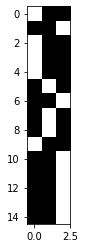

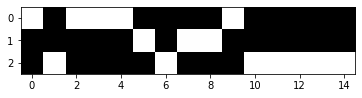

In [93]:
plt.imshow(output, cmap='gray')
plt.show()
plt.imshow(output.T, cmap = 'gray') # transpose
plt.show()
# img = output * 255



In [86]:
# 모델 평가하기
scores = model.evaluate_generator( test_generator, steps = 5)
print(scores)
print("the valid_accuracy = ", scores[1])

[0.0, 0.800000011920929]
the valid_accuracy =  0.800000011920929


In [94]:
labels = ['C', 'R', 'T']

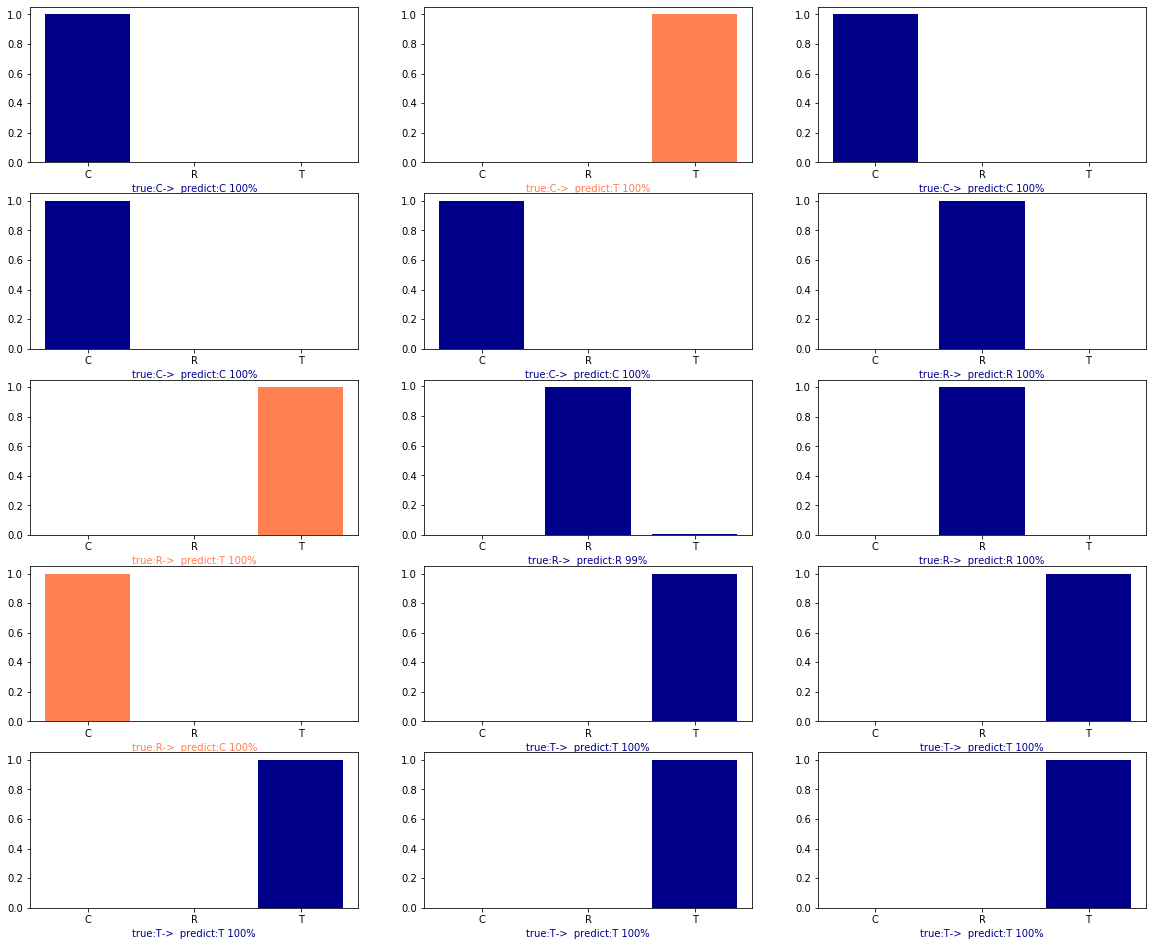

In [112]:
idx = [ 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
# idx = [2,5,6,7]

plt.figure(figsize=(20, 20))

cc = 3
rr = int(len(idx) / cc)+1

for k in range( len(idx) ) :        
  i = idx[k]             
  c =  "darkblue" if  p[i] == T[i]   else "coral"    
  plt.subplot( rr ,cc, k+1)
  plt.bar(labels, output[i], color=c)
  plt.xlabel("true:{}->  predict:{} {:2.0f}%".format(labels[int(T[  i ])], 
                                                     labels[p[  i ]], 
                                                     100*np.max(output[i], axis=0)),  
             color = c )

In [145]:
test_generator = test_datagen.flow_from_directory("hard_handwriting_shape/test",
                                                 target_size = (24,24),
                                                 batch_size=15,
                                                 class_mode='binary', shuffle=False)
a = test_generator.next()
X, T = a
print(a[0].shape)
print(a[1].shape)
# 위에서는 T = test_generator.classes 라고 정의했는데 사실 같은 것임

output = model.predict(X)
p = np.argmax(output, axis=1)

Found 15 images belonging to 3 classes.
(15, 24, 24, 3)
(15,)


index =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


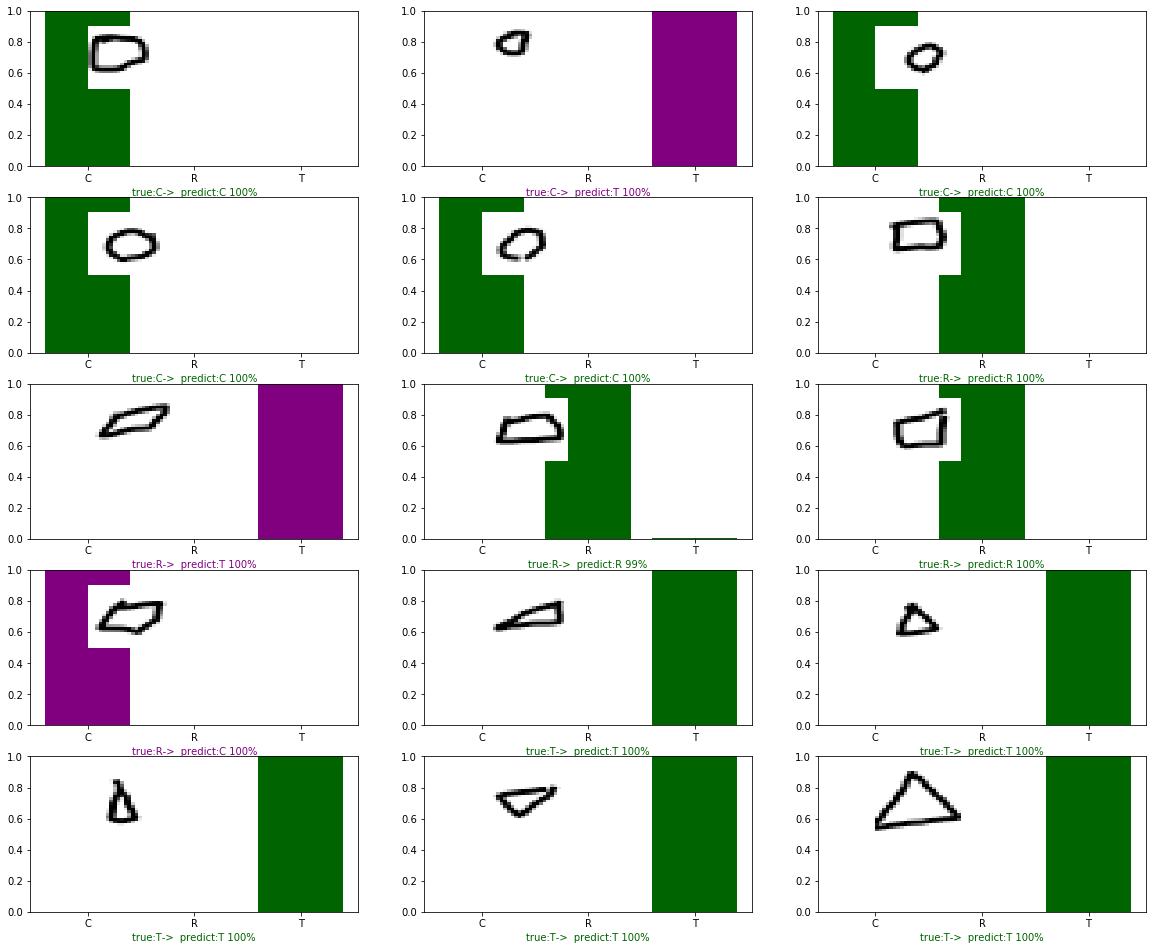

In [146]:
# 15개 모두 비교

# idx = np.where(  p != T )
idx = [ 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
print("index = ", idx)

plt.figure(figsize=(20, 20))

cc = 3
rr = int(len(idx) / cc)+1

for k in range( len(idx) ) :        
  i = idx[k]             
  c =  "darkgreen" if  p[i] == T[i]   else "purple"    
  plt.subplot( rr ,cc, k+1)
  #  left and right limits, and the bottom and top limits. 
  plt.imshow(a[0][i, :,:, 0], extent=[0, 0.8, 0.5, 0.9], aspect='auto', zorder=10, cmap="gray")
  plt.ylim(0.0, 1.0)  
  plt.bar(labels, output[i], color=c)
  plt.xlabel("true:{}->  predict:{} {:2.0f}%".format(labels[int(T[  i ])], 
                                                     labels[p[  i ]],  
                                                     100*np.max(output[i], 
                                                                axis=0)),  
             color = c )
    
# plt.savefig('fig1.png')

index =  (array([1, 6, 9], dtype=int64),)


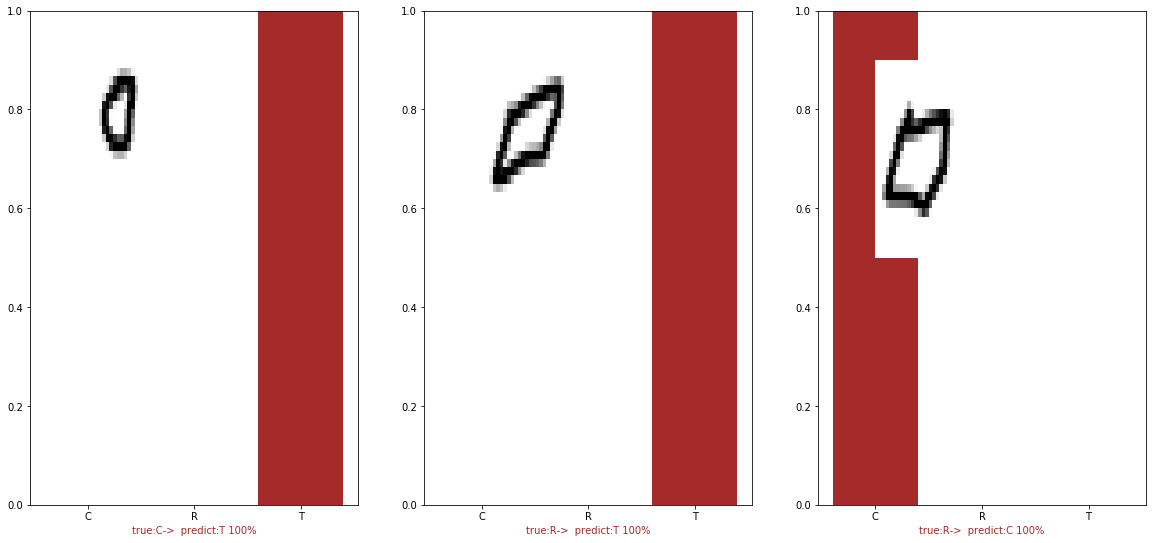

In [149]:
# True값과 Prediction값이 다른 곳에서만 비교


idx = np.where(  p != T )
print("index = ", idx)

plt.figure(figsize=(20, 20))

cc = 3
rr = int(len(idx[0]) / cc)+1

for k in range( len(idx[0]) ) :        
  i = idx[0][k]             
  c =  "blue" if  p[i] == T[i]   else "brown"    
  plt.subplot( rr ,cc, k+1)
  #  left and right limits, and the bottom and top limits. 
  plt.imshow(a[0][i, :,:, 0], extent=[0, 0.8, 0.5, 0.9], aspect='auto', zorder=10, cmap="gray")
  plt.ylim(0.0, 1.0)  
  plt.bar(labels, output[i], color=c)
  plt.xlabel("true:{}->  predict:{} {:2.0f}%".format(labels[int(T[  i ])], 
                                                     labels[p[  i ]],  
                                                     100*np.max(output[i], 
                                                                axis=0)),  
             color = c )
    
# plt.savefig('fig1.png')

---